In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import pathlib
import eda_utils
import json
import seaborn as sns

In [8]:
plt.style.use('default')

In [4]:
dataset_dir = pathlib.Path('../data/raw/skin_cancer_mnist')

In [5]:
with open('../data/processed/class_matchings/skin_cancer_mnist.json') as f:
    class_matching = json.load(f)

In [6]:
df = pd.read_csv(dataset_dir.joinpath('HAM10000_metadata.csv'))

## Распределение классов

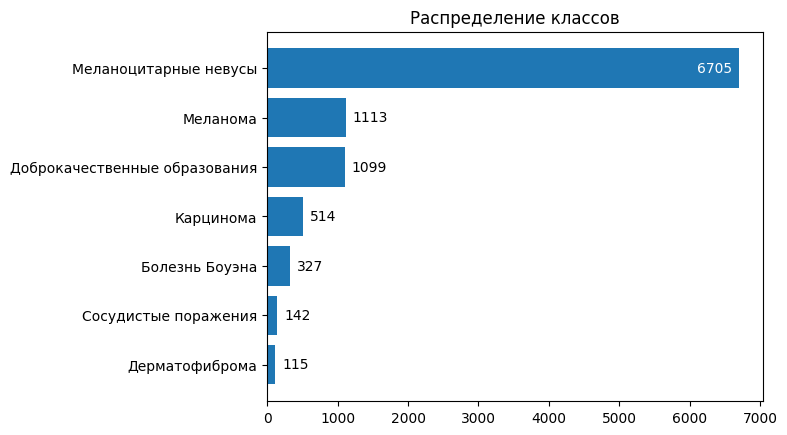

In [9]:
fig, ax = plt.subplots()
eda_utils.plot_count_bar(df['dx'].apply(lambda x: class_matching[x]), ax=ax, counts_text_offset=100)
ax.set_title('Распределение классов');

## Примеры изображений

In [10]:
def plot_class_examples(class_title: str):
    image_ids = df[df['dx'] == class_title].sample(16, random_state=10)['image_id'].values
    images = []
    for image_id in image_ids:
        fp = next(dataset_dir.glob(f'*/{image_id}*'))
        images.append(Image.open(fp))
    fig, axs = eda_utils.plot_images_grid(images)
    fig.suptitle(class_matching[class_title])

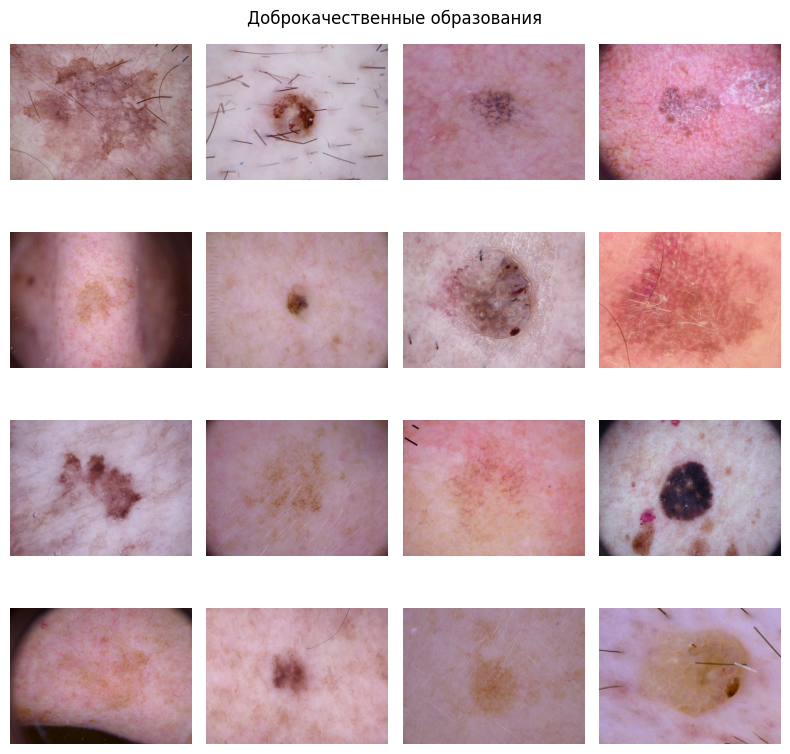

In [11]:
plot_class_examples('bkl')

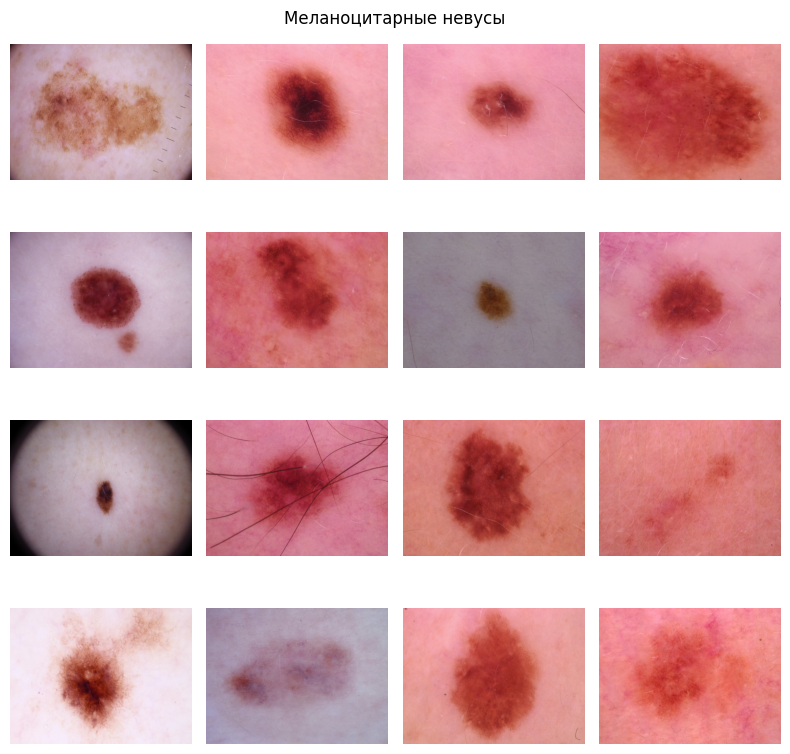

In [12]:
plot_class_examples('nv')

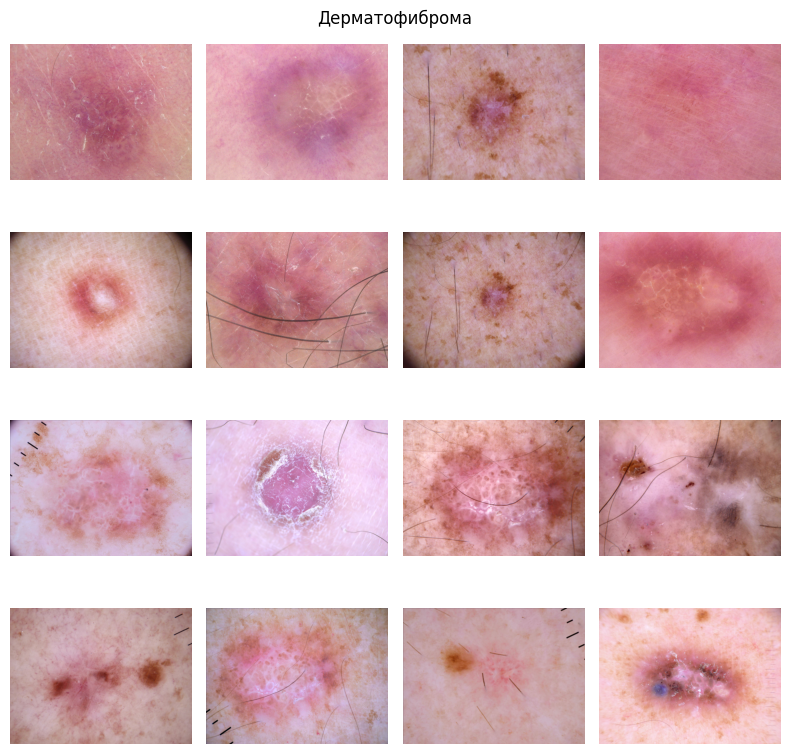

In [13]:
plot_class_examples('df')

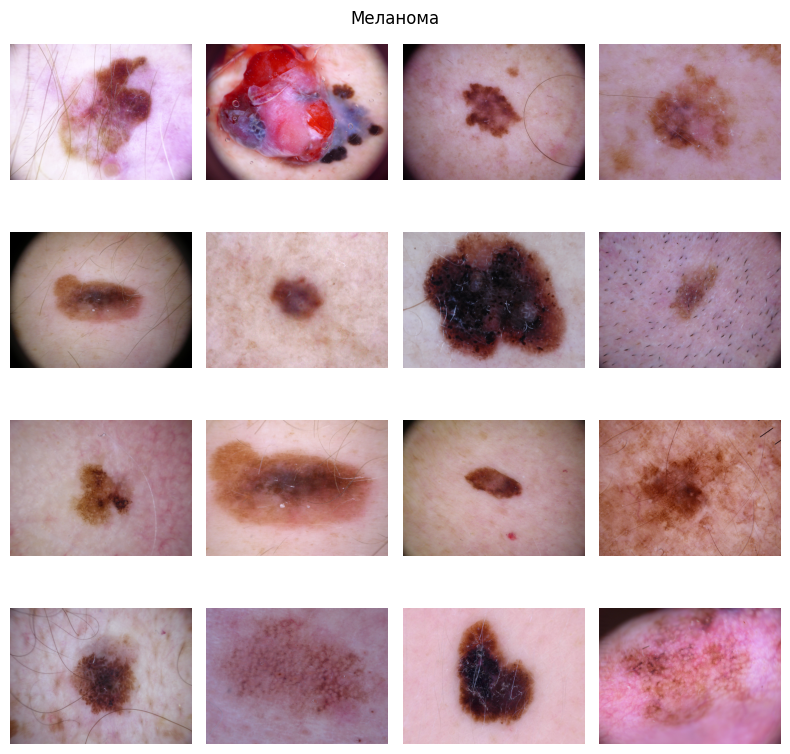

In [14]:
plot_class_examples('mel')

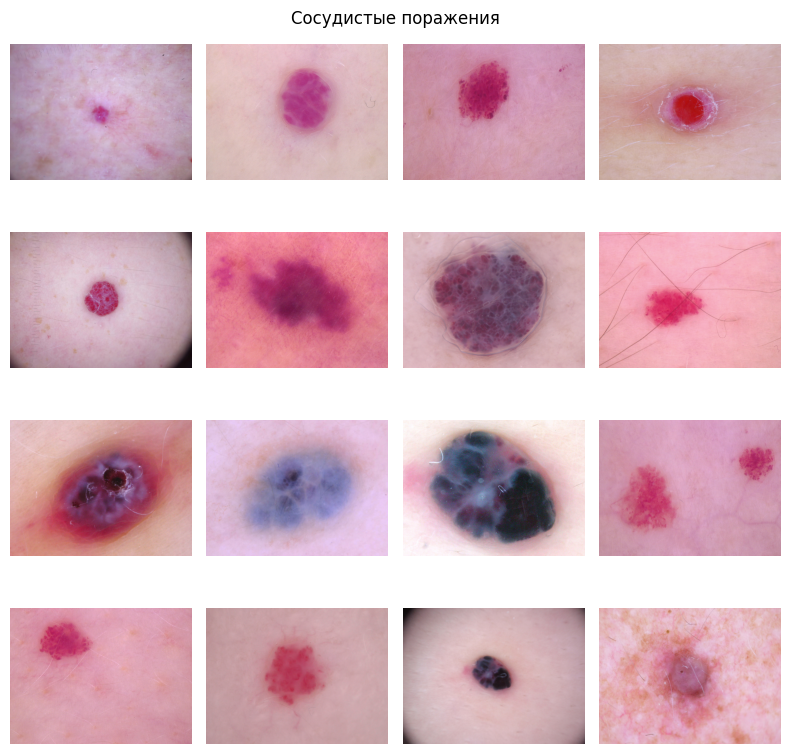

In [15]:
plot_class_examples('vasc')

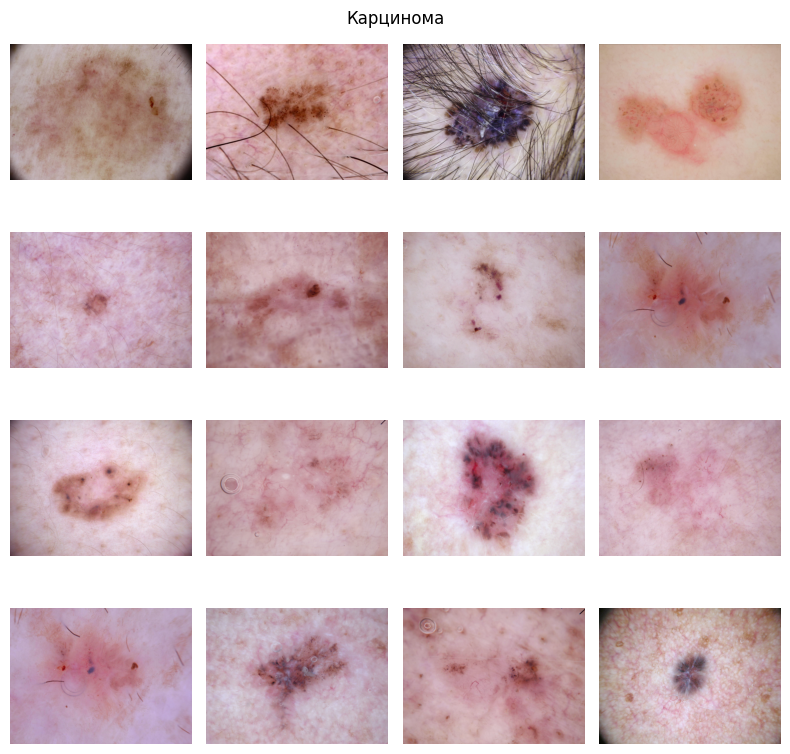

In [16]:
plot_class_examples('bcc')

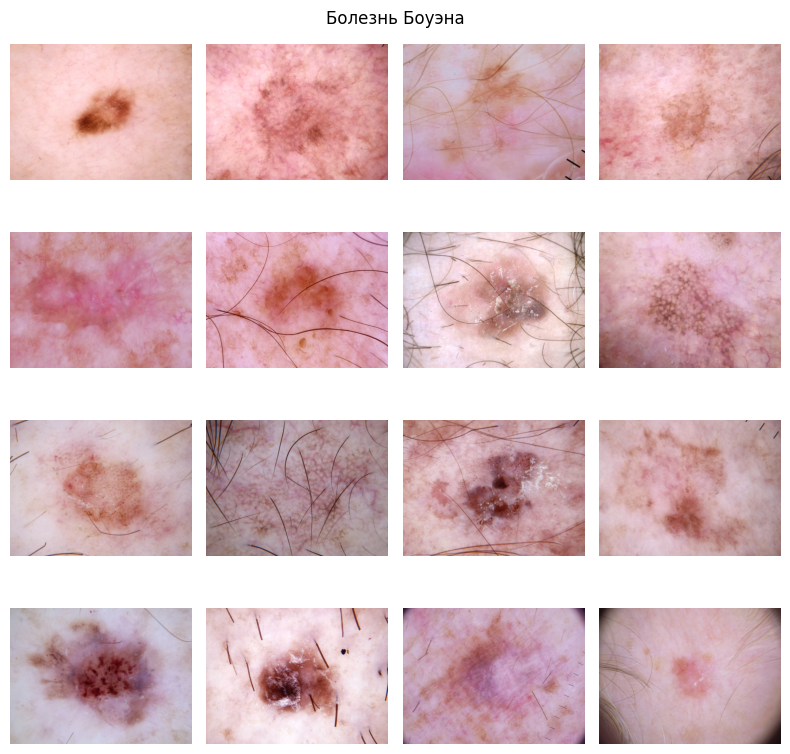

In [17]:
plot_class_examples('akiec')

## Pixel values

In [20]:
pixel_value_mean = np.zeros(3, dtype=np.float32)
pixel_value_std = np.zeros(3, dtype=np.float32)

pixel_counts = 0
for i, row in tqdm(df.iterrows(), total=len(df)):
    image_id = row['image_id']
    class_title = class_matching[row['dx']]
    image_fp = next(dataset_dir.glob(f'ham10000_images_part*/{image_id}*'))
    image = np.array(Image.open(image_fp))

    current_mean = image.mean(axis=(0, 1))
    current_std = image.std(axis=(0, 1))
    current_pixel_counts = image.shape[0] * image.shape[1]

    tmp = pixel_value_mean

    pixel_value_mean = pixel_counts / (
                pixel_counts + current_pixel_counts) * pixel_value_mean + current_pixel_counts / (
                                   pixel_counts + current_pixel_counts) * current_mean
    pixel_value_std = np.sqrt(
        pixel_counts / (pixel_counts + current_pixel_counts) * pixel_value_std ** 2 + current_pixel_counts / (
                    pixel_counts + current_pixel_counts) * current_std ** 2 + pixel_counts * current_pixel_counts / (
                    pixel_counts + current_pixel_counts) ** 2 * (tmp - current_mean) ** 2)

    pixel_counts += current_pixel_counts

100%|██████████| 10015/10015 [07:50<00:00, 21.27it/s]


In [21]:
print(f'{pixel_value_mean=}')
print(f'{pixel_value_std=}')

pixel_value_mean=array([194.69790581, 139.26262878, 145.48525508])
pixel_value_std=array([36.00903465, 38.98722064, 43.43363662])


<AxesSubplot:>

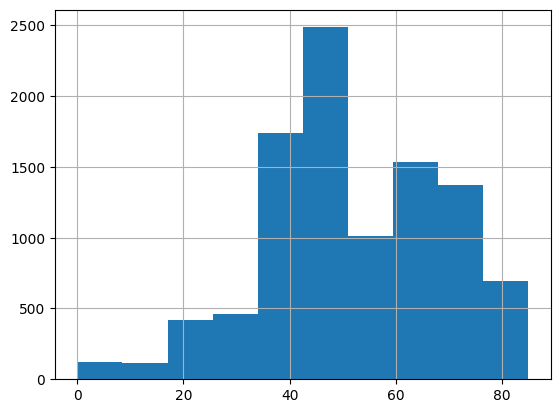

In [18]:
df['age'].hist()

# Соотношение возраста к патологии

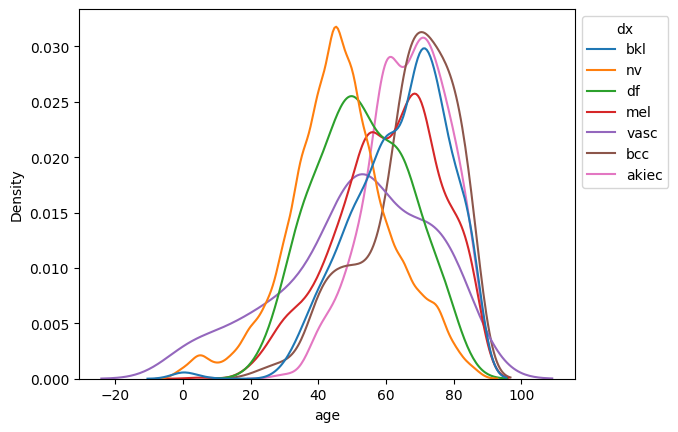

In [19]:
ax = sns.kdeplot(data=df, x='age', hue='dx', common_norm=False, legend=True)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))